# TCLab: Open-Loop Optimization and Estimation using Pyomo

## Learning Objectives

1. Compute optimal heater strategy using physics-based model
2. Verify open loop performance with TC Lab simulation
3. Estimate unmeasured states (heater temperature) using model

In [1]:
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/IDAES/idaes-pse/main/scripts/colab_helper.py"
    import colab_helper
    colab_helper.install_idaes()
    colab_helper.install_ipopt()
    !pip install tclab

## Mathematical Model and Pyomo Simulation

Recall the two-state model for a single heater/sensor assembly:

\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_b (T_S - T_H) + \alpha P u(t) + d(t)\\
C_p^S \frac{dT_S}{dt} & = - U_b (T_S - T_H) 
\end{align*}

### Pyomo Model

The code block below provides a library for performing several analysis tasks with our model. This is a `class`, which is a more sophisticated way to modularize our code. Briefly, classes store both data and methods to manipualte the data.

Take a few minutes to study this code. Note the missing lines of code to fill in when you get to Exercise 1. A few features:
* It supports four modes:
  * `simulate`: solve the model with all of the inputs specified (zero degrees of freedom)
  * `optimize`: determine the best $u(t)$ to track the desired $T_{set}(t)$
  * `observe`: estimate the unmeasured state $T_{H}(t)$ and disturbance $d(t)$ from experimental data
  * `estimate`: estimate the model parameters $U_a$, $U_b$, $C_p^H$, $C_p^S$ from experimental data
* The `__init__` method is called automatically when you create an instance of the object. The initial method is how you pass in data
* The `solve` method call the numerical optimization algorithm
* The `plot` method plots the Pyomo results
* The `get_Ts`, `get_Th`, `get_U`, and `get_D` methods return data stored in the Pyomo model after it is solved

This notebook walks you through using the library. The take away message is that a class is a convient way to modularize our code and maximize reuse. The four supported modes are very similar.

In [2]:
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np

# ensure that IDAES is imported if there is an error calling Ipopt
import idaes

# Protip: only import the functions you need for each library.
# This tells other programs exactly where each function is defined.
# Avoid using from pyomo.environ import * as this imports everything
from pyomo.environ import ConcreteModel, Var, Param, Constraint, TransformationFactory, SolverFactory, Objective, minimize, value, Suffix
from pyomo.dae import DerivativeVar, ContinuousSet, Simulator

##### IMPORTANT #####
# When you do Lab 5, you need to update Ua, Ub, CpH, and CpS to the values
# you previously estimated for your hardware.
#
#####################

class TCLabPyomo:
    '''
    This class contains the methods used for simulating the TCLab model, optimizing u(t) per a 
    given set point for T, observing a disturbance, and estimating model parameters in the TCLab.
    '''

    def __init__(self, mode, t_data, u_data, d_data, Tset_data, 
                 TS_data, Tamb = 21.0, alpha = 0.00016, P1 = 100,
                 Ua = 0.0268, Ub = 0.0029, CpH = 3.678, CpS = 0.054,
                 integrate_to_initialize=True, obj_weight=0.1
    ):
        '''
        Method called automatically when instantiating class.
        Arguments:
            mode: specify mode
            t_data: time data
            u_data: input control data
            d_data: disturbance data
            Tset_data: set point data
            TS_data: experimental data
            Tamb: ambient temperature, deg C
            alpha: watts / (units P1 * percent U1)
            P1: max power, P1 units
            Ua: heat transfer coefficient from heater to environment, watts/deg C
            Ub: heat transfer coefficient from heater to sensor, watts/deg C
            CpH: heat capacity of the heater, joules/deg C
            CpS: heat capacity of the, joules/deg C
            integrate_to_initialize: Boolean
            obj_weight: weight for heater temperature or disturbance in objective function, default is 0.1
        Returns:
            None 
        '''
        
        # establish the valid operating modes
        valid_modes = ['simulate','optimize','estimate','observe']

        # raise an error if the user feeds in invalid operating mode
        if mode not in valid_modes:
            raise ValueError("'mode' must be one of the following:"+valid_modes)

        # define mode and data
        self.mode = mode
        self.t_data = t_data
        self.u_data = u_data
        self.d_data = d_data
        self.Tset_data = Tset_data
        self.TS_data = TS_data

        # set parameter values
        self.Tamb = Tamb
        self.Ua = Ua
        self.Ub = Ub
        self.CpH = CpH
        self.CpS = CpS
        self.P1 = P1
        self.alphaP = alpha*P1
        self.integrate_to_initialize = integrate_to_initialize
        self.obj_weight = obj_weight

        # create the pyomo model
        self._create_pyomo_model()

        return None


    def _create_pyomo_model(self):
        '''
        Method that creates and defines the pyomo model for each mode.
        Arguments:
            None
        Returns:
            m: the pyomo model
        '''
        
        # create the pyomo model
        m = ConcreteModel()

        # create the time set
        m.t = ContinuousSet(initialize = self.t_data)  # make sure the experimental time grid are discretization points
        # define the heater and sensor temperatures as variables
        # Increased temperature bounds to 85 deg C for digital twin mode
        m.Th = Var(m.t, bounds=[0, 85], initialize=self.Tamb)
        m.Ts = Var(m.t, bounds=[0, 85], initialize=self.Tamb)

        def helper(my_array):
            '''
            Method that builds a dictionary to help initialization.
            Arguments:
                my_array: an array
            Returns:
                data: a dict {time: array_value}
            '''
            # ensure that the dimensions of array and time data match
            assert len(my_array) == len(self.t_data), "Dimension mismatch."
            data = {}
            for k,t in enumerate(self.t_data):
                data[t] = my_array[k]
            return data

        # for the simulate, observe, estimate modes
        if self.mode in ['simulate', 'observe', 'estimate']:
            # control decision is a parameter initialized with the input control data dict
            m.U = Param(m.t, initialize=helper(self.u_data), default = 0)
        else:
            # otherwise (optimize) control decision is a variable
            m.U = Var(m.t, bounds=(0, 100))

        # for the simulate, optimize, estimate modes
        if self.mode in ['simulate', 'optimize', 'estimate']:
            # if no distrubance data exists, initialize parameter at 0
            if self.d_data is None:
                 m.D = Param(m.t, default = 0)
            # otherwise initialize parameter with disturbance data dict
            else:
                m.D = Param(m.t, initialize=helper(self.d_data))
        # otherwise (observe) the disturbance is a variable
        else:
            m.D = Var(m.t)

        # define parameters that do not depend on mode
        m.Tamb = Param(initialize=self.Tamb)
        m.alphaP = Param(initialize=self.alphaP)

        # for the simulate, optimize, observe modes
        if self.mode in ['simulate', 'optimize', 'observe']:
            # Ua and Ub parameters
            m.Ua = Param(initialize=self.Ua)
            m.Ub = Param(initialize=self.Ub)
            # 1/CpH and 1/CpS parameters
            m.inv_CpH = Param(initialize=1/self.CpH)
            m.inv_CpS = Param(initialize=1/self.CpS)
        # otherwise (estimate) they are variables
        else:
            m.Ua = Var(initialize=self.Ua, bounds=(1E-5, 2.0))
            m.Ub = Var(initialize=self.Ub, bounds=(1E-5, 2.0))
            m.inv_CpH = Var(initialize=1/self.CpH, bounds=(1E-2,100))
            m.inv_CpS = Var(initialize=1/self.CpS, bounds=(1E-1, 1000))



        # define variables for change in temperature wrt to time
        m.Thdot = DerivativeVar(m.Th, wrt = m.t)
        m.Tsdot = DerivativeVar(m.Ts, wrt = m.t)

        # define differential equations (model) as contraints
        # moved Cps to the right hand side to diagnose integrator
        m.Th_ode = Constraint(m.t, rule = lambda m, t: 
                            m.Thdot[t] == (m.Ua*(m.Tamb - m.Th[t]) + m.Ub*(m.Ts[t] - m.Th[t]) + m.alphaP*m.U[t] + m.D[t])*m.inv_CpH)
        m.Ts_ode = Constraint(m.t, rule = lambda m, t: 
                            m.Tsdot[t] == (m.Ub*(m.Th[t] - m.Ts[t]) )*m.inv_CpS)


        

        ##### Simulate to initialize
        # Specify time-varying input data
        # This is a dictionary of the form {time: value}
        # This is used only for the simulate mode,
        # which just initializes the model
        if self.integrate_to_initialize:

            m.var_input = Suffix(direction=Suffix.LOCAL)

            if self.u_data is not None:
                # initialize with data
                m.var_input[m.U] = helper(self.u_data)
            else:
                # otherwise initialize control decision of 0
                m.var_input[m.U] = {0:0}

            if self.d_data is not None:
                # initialize with data
                m.var_input[m.D] = helper(self.d_data)
            else:
                # otherwise initialize disturbance of 0
                m.var_input[m.D] = {0:0}
            

            # Simulate to initiialize
            # Makes the solver more efficient
            sim = Simulator(m, package='scipy') 
            tsim, profiles = sim.simulate(numpoints=100, 
                                        integrator='vode', 
                                        varying_inputs=m.var_input)
            sim.initialize_model()

        # In Lab 5, you will add constraints limiting the 
        # rate of change of the heater power (u) here.

        # for the optimize mode, set point data is a parameter
        if self.mode == 'optimize':
            m.Tset = Param(m.t, initialize=helper(self.Tset_data))
            # otherwise, we are not using it

        # for the estimate and observe modes, experimental data is a parameter
        if self.mode in ['estimate', 'observe']:
            m.Ts_measure = Param(m.t, initialize=helper(self.TS_data))
            # otherwise, we are not using it

        # apply backward finite difference to the model
        TransformationFactory('dae.finite_difference').apply_to(m, scheme='BACKWARD',nfe=len(self.t_data)-1)

        if self.mode == 'optimize':
            # defining the tracking objective function
            m.obj = Objective(expr=sum( (m.Ts[t] - m.Tset[t])**2 + self.obj_weight*(m.Th[t] - m.Tset[t])**2 for t in m.t), sense=minimize)

        if self.mode == 'observe':
            # define observation (state estimation)
            m.obj = Objective(expr=sum((m.Ts[t] - m.Ts_measure[t])**2 + self.obj_weight*m.D[t]**2 for t in m.t), sense=minimize)

        if self.mode == 'estimate':
            # define parameter estimation objective
            m.obj = Objective(expr=sum((m.Ts[t] - m.Ts_measure[t])**2 for t in m.t), sense=minimize)

        # initial conditions
        if self.TS_data is not None:
            # Initilize with first temperature measurement
            m.Ts[0].fix(self.TS_data[0])
            m.Th[0].fix(self.TS_data[0])
        else:
            # Otherwise, initialize with Tamb
            m.Th[0].fix(m.Tamb)
            m.Ts[0].fix(m.Tamb)

        self.m = m
    

    def solve(self):
        '''
        Solves the pyomo model using ipopt.
        '''
        solver = SolverFactory('ipopt')
        #solver.options['linear_solver'] = 'ma57'
        solver.solve(self.m, tee=True)


    def get_time(self):
        '''
        Returns time data from solved pyomo model.
        '''
        return self.t_data


    def get_Th(self):
        '''
        Returns heater temperature data from solved pyomo model.
        '''
        return np.array([value(self.m.Th[t]) for t in self.t_data])
    

    def get_Ts(self):
        '''
        Returns sensor temperature data from solved pyomo model.
        '''
        return np.array([value(self.m.Ts[t]) for t in self.t_data])
    

    def get_U(self):
        '''
        Returns control decision data from solved pyomo model.
        '''
        return np.array([value(self.m.U[t]) for t in self.t_data])
    

    def get_D(self):
        '''
        Returns disturbance data from solved pyomo model.
        '''
        return np.array([value(self.m.D[t]) for t in self.t_data])
    

    def get_parameters(self):
        '''
        Returns model parameters from solved pyomo model.
        '''
        return value(self.m.Ua), value(self.m.Ub), 1/value(self.m.inv_CpH), 1/value(self.m.inv_CpS)


    def print_parameters(self):
        '''
        Prints out the model parameters from solved pyomo model.
        '''
        Ua, Ub, CpH, CpS = self.get_parameters()

        print("The value of Ua is", round(Ua,4), "Watts/degC.")
        print("The value of Ub is", round(Ub,4), "Watts/degC.")
        print("The value of CpH is", round(CpH,3), "Joules/degC.")
        print("The value of CpS is", round(CpS,3),"Joules/degC.")


    def plot(self):
        '''
        Method to plot the results from the pyomo model.
        '''

        # extract predictions
        Th = self.get_Th()
        Ts = self.get_Ts()
        U = self.get_U()
        D = self.get_D()

        # create figure
        plt.figure(figsize=(10,6))

        # subplot 1: temperatures
        plt.subplot(3, 1, 1)
        if self.TS_data is not None:
            plt.scatter(self.t_data, self.TS_data, marker='.', label="$T_{S}$ measured", alpha=0.5,color='green')
        plt.plot(self.t_data, Th, label='$T_{H}$ predicted')
        plt.plot(self.t_data, Ts, label='$T_{S}$ predicted')
        if self.Tset_data is not None:
            plt.plot(self.t_data, self.Tset_data, label='$T_{set}$')

        plt.title('temperatures')
        plt.ylabel('deg C')
        plt.legend()
        plt.grid(True)

        # subplot 2: control decision
        plt.subplot(3, 1, 2)
        plt.plot(self.t_data, U)
        plt.title('heater power')
        plt.ylabel('percent of max')
        plt.grid(True)

        # subplot 3: disturbance
        plt.subplot(3, 1, 3)
        plt.plot(self.t_data, D)
        plt.title('disturbance')
        plt.ylabel('watts')
        plt.xlabel('time (s)')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

### Process Inputs

The next cell defines some process inputs that will be used throughout the notebook to demonstrate aspects of process simulation, control, and estimation.  These are gathered in one place to make it easier to modify the notebook to test the response under different conditions. These functions are implemented using the `interp1d` from the `scipy` library.

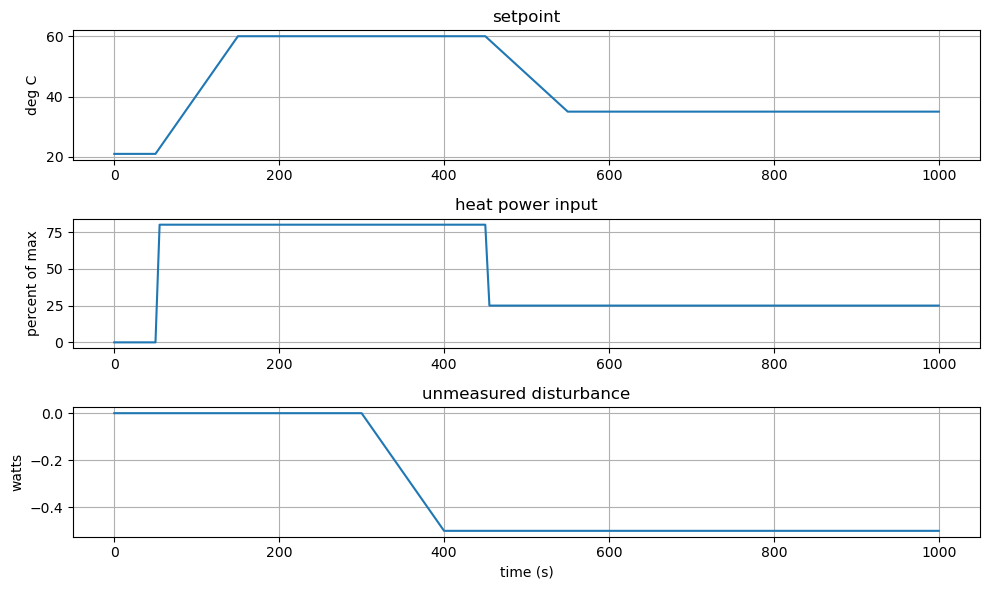

In [3]:
%matplotlib inline

# Ambient temperature
# In Lab 5, you will update this based on the room's temperature
Tamb = 21.0 # deg C

tclab_disturbance = interpolate.interp1d(
    [ 0, 300, 400, 9999],   # time
    [ 0, 0, -.5, -.5],      # disturbance value
    fill_value="extrapolate")   # tolerates slight exptrapolation

tclab_input = interpolate.interp1d(
    [ 0, 50, 51, 450, 451, 9999],   # time
    [ 0,  0, 80,  80,   25,   25],  # input value
    fill_value="extrapolate")   # tolerates slight exptrapolation

tclab_setpoint = interpolate.interp1d(
    [0, 50, 150, 450, 550, 9999],   # time 
    [Tamb, Tamb, 60, 60, 35, 35],   # set point value
    fill_value="extrapolate")   # tolerates slight exptrapolation`

t_sim = np.linspace(0, 1000, 201)       # create 201 time points between 0 and 1000 seconds
u_sim = tclab_input(t_sim)              # calculate input signal at time points
d_sim = tclab_disturbance(t_sim)        # calculate disturbance at time points
setpoint_sim = tclab_setpoint(t_sim)    # calculate set point at time points

plt.figure(figsize=(10,6))
plt.subplot(3, 1, 1)
plt.plot(t_sim, setpoint_sim)
plt.title('setpoint')
plt.ylabel('deg C')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(t_sim, u_sim)
plt.title('heat power input')
plt.ylabel('percent of max')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(t_sim, d_sim)
plt.title('unmeasured disturbance')
plt.ylabel('watts')
plt.xlabel('time (s)')
plt.grid(True)

plt.tight_layout()

Let's see how well our initial guess at a control strategy will work for us.

\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_b (T_S - T_H) + \alpha P u(t) + d(t)\\
C_p^S \frac{dT_S}{dt} & = - U_b (T_S - T_H) 
\end{align*}

subject to initial conditions

\begin{align*}
T_H(t_0) & = T_{amb} \\
T_S(t_0) & = T_{amb}
\end{align*}

and prior specification of inputs $u(t)$ and $d(t)$.

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

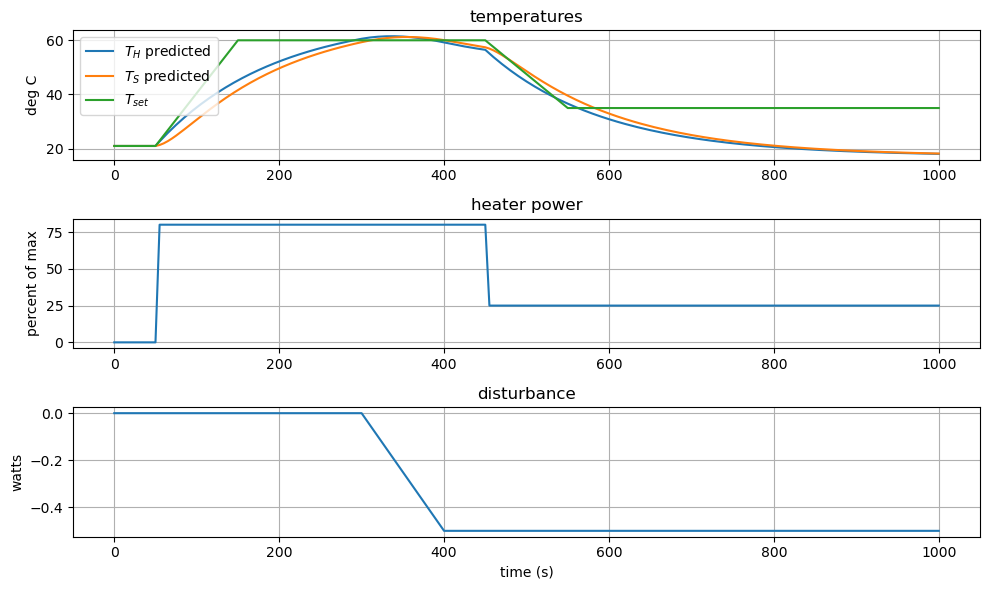

In [4]:
sim = TCLabPyomo('simulate',
                t_sim,
                u_sim,
                d_sim,
                setpoint_sim,
                None,
)

sim.solve()
sim.plot()

## Optimal Control with Knowledge of Disturbances

An optimal control policy minimizes the differences

\begin{align*}
\min_{u} \int_{t_0}^{t_f} \|T_S^{SP}(t) - T_S(t)\|^2\ + w \|T_S^{SP}(t) - T_H(t)\|^2\,dt \\
\end{align*}

subject to constraints

\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_c (T_S - T_H) + P u(t) + d(t)\\
C_p^S \frac{dT_S}{dt} & = - U_c (T_S - T_H) 
\end{align*}

initial conditions

\begin{align*}
T_H(t_0) & = T_{amb} \\
T_S(t_0) & = T_{amb}
\end{align*}

and prior knowledge of $d(t)$.

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

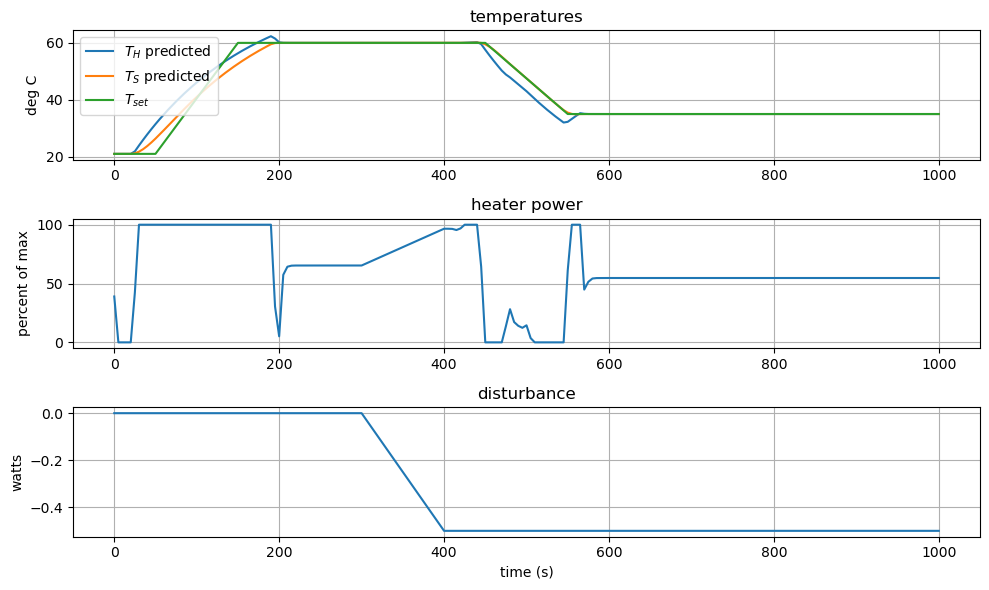

In [5]:
opt = TCLabPyomo('optimize',
                 t_sim,
                 u_sim,
                 d_sim,
                 setpoint_sim,
                 None,
                 obj_weight=0.01
)

opt.solve()
opt.plot()

## Hardware Implementation

Implement your calculated solution on the TC Lab hardware (in "digital twin" mode). Save the simulation results to a text file.

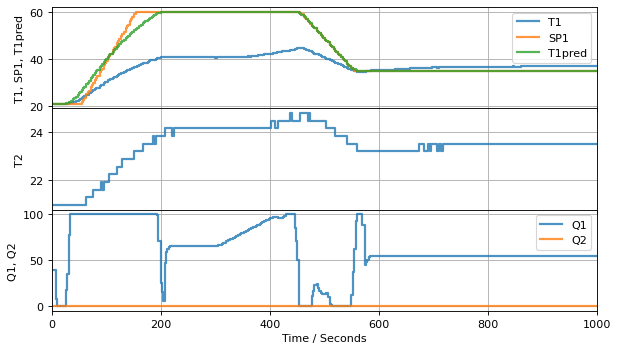

TCLab Model disconnected successfully.


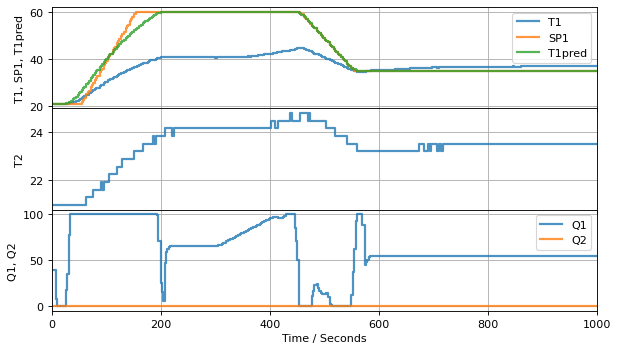

In [6]:
t_solution = opt.get_time()
u_solution = opt.get_U()
TS_solution = opt.get_Ts()
TH_solution = opt.get_Th()

u_open_loop = interpolate.interp1d(
    t_solution,   # time
    u_solution,   # control value
    fill_value="extrapolate")   # tolerates slight exptrapolation

TS_predict = interpolate.interp1d(
    t_solution,   # time
    TS_solution,   # sensor temperature prediction
    fill_value="extrapolate")   # tolerates slight exptrapolation

TH_predict = interpolate.interp1d(
    t_solution,   # time
    TH_solution,   # sensor temperature prediction
    fill_value="extrapolate")   # tolerates slight exptrapolation

from tclab import TCLab, clock, Historian, Plotter, setup

# In Lab 5, you will use connected=True
# And run this experiment on your hardware
TCLab = setup(connected=False, speedup=20)

# Set final time to match simulation
t_final = t_solution[-1]

# Only implement the controller change every 2 seconds
t_step = 2.0

# Run experiments
with TCLab() as lab:

    # Define sources for plotting
    sources = [("T1", lambda: lab.T1), ("T2", lambda: lab.T2),
            ("T1pred", lambda: TS_predict(t)),
            ("SP1", lambda: tclab_setpoint(t)),
            ("Q1", lab.Q1), ("Q2", lab.Q2)]
    
    # Create a historian to store data
    h = Historian(sources)
    # Define plotting using same names as sources/historian
    p = Plotter(h, t_final, layout=(("T1", "SP1","T1pred"), ("T2",), ("Q1", "Q2")))

    lab.P1 = opt.P1

    # Loop over time steps
    for t in clock(t_final, t_step):
        # Look up the control value via interpolation
        U1 = u_open_loop(t)

        # Notice, we did not apply the distrubance here

        # Set control value to hardware
        lab.Q1(U1)

        # Update the plot
        p.update()

In [7]:
import os.path

def save_tclab_data(h, file_name, overwrite_file=False):
    '''
    Save TCLab data to csv file
    Arguments:
        h: tclab historian objective
        file_name: valid file name as a string
        overwrite_file: bool, if True, overwrite exisiting file
            default is False to safeguard against accidentally rerunning this function
    '''

    if not overwrite_file and os.path.isfile('./'+file_name):
        raise FileExistsError(file_name + ' already exisits. Either choose a new filename or set overwrite_file = True.')
    else:
        h.to_csv(file_name)
        print("Successfully saved data to "+file_name)

    return file_name

excercise2_tclab_data_file = 'tclab-open-loop-digital-twin.csv'

data_file = save_tclab_data(h,
                excercise2_tclab_data_file,
                True
)

Successfully saved data to tclab-open-loop-digital-twin.csv


## Estimation/Observation

> "... and now my watch begins ..." ―The Night's Watch oath, Game of Thrones

The trouble with open-loop optimal control is that we cannot anticipate or know the values of unmeasured disturbances, much less the future values of those disturbances. The best we can do is use available data and process models to estimate the process state and disturbances. The state estimation problem is:


\begin{align*}
\min_{\hat{T}_H, \hat{T}_S, \hat{d}} \int_{t - h}^t (\|\hat{T}_S(t) - T_S(t)\|^2\, + wd(t)^2 ) dt \\
\end{align*}

subject to

\begin{align*}
C_p^H \frac{d\hat{T}_H}{dt} & = U_a (T_{amb} - \hat{T}_H) + U_c (\hat{T}_S - \hat{T}_H) + P u(t) + \hat{d}(t)\\
C_p^S \frac{d\hat{T}_S}{dt} & = - U_c (\hat{T}_S - \hat{T}_H) 
\end{align*}

and initial conditions

\begin{align*}
T_H(t_0) & = T_{amb} \\
T_S(t_0) & = T_{amb}
\end{align*}


Using the experimental data generated above, estimate the heater temperature and disturbance.

In [8]:
excercise3_tclab_data_file = 'tclab-open-loop-digital-twin.csv'

In [9]:
import pandas as pd
experiment_data = pd.read_csv(excercise3_tclab_data_file)
experiment_data.head()


,Time,T1,T2,T1pred,SP1,Q1,Q2
0,3.846364,20.9495,20.9495,21.0,21.0,3.898698e+01,0
1,7.908338,20.9495,20.9495,21.0,21.0,7.329552e+00,0
2,9.926335,20.9495,20.9495,21.0,21.0,4.255916e-09,0
3,11.857711,20.9495,20.9495,21.0,21.0,5.186205e-09,0
4,15.903075,20.9495,20.9495,21.0,21.0,8.259456e-09,0


In [10]:
time_data = experiment_data['Time'].array # grab column from pandas, convert to array
time_data -= time_data[0] # make initial time 0

u_data = experiment_data['Q1'].array
T1_data = experiment_data['T1'].array

### Small Objective Weight ($w=0.01$)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

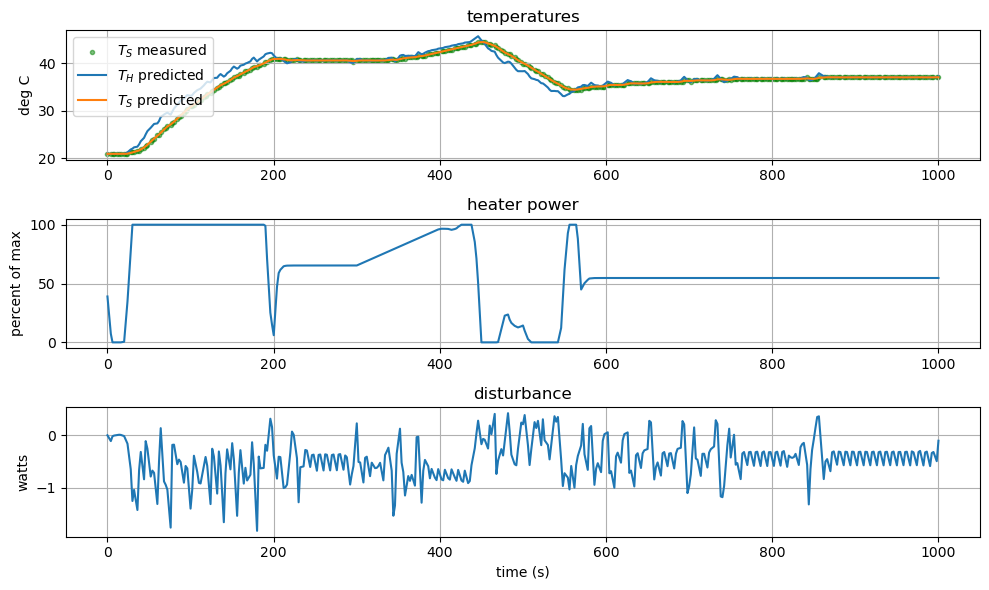

In [11]:
obs = TCLabPyomo('observe',
                 time_data,
                 u_data,
                 None,
                 None,
                 T1_data,
                obj_weight=0.01
)

obs.solve()
obs.plot()

### Medium Objective Weight $w=0.1$

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

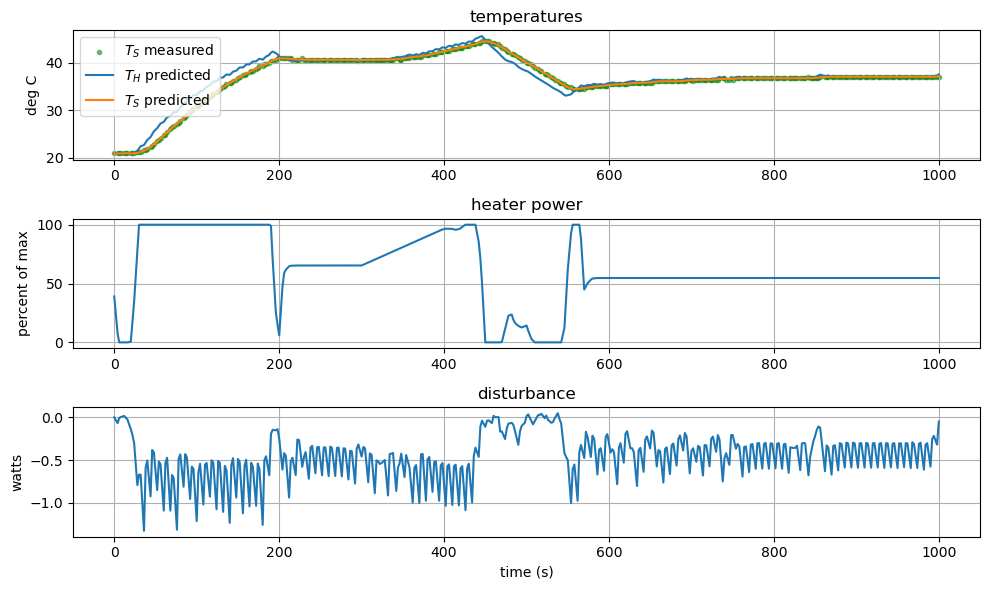

In [12]:
obs = TCLabPyomo('observe',
                 time_data,
                 u_data,
                 None,
                 None,
                 T1_data,
                obj_weight=0.1
)

obs.solve()
obs.plot()

### Medium Large Objective Weight ($w=1$)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

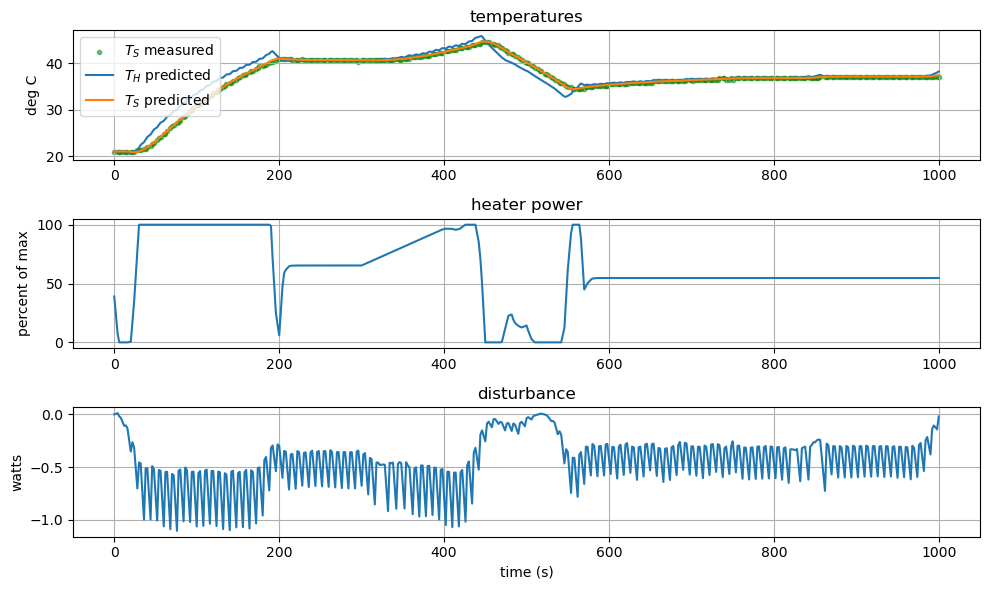

In [13]:
obs = TCLabPyomo('observe',
                 time_data,
                 u_data,
                 None,
                 None,
                 T1_data,
                obj_weight=1.0
)

obs.solve()
obs.plot()

## Extra Large Objective Weight ($w=10$)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

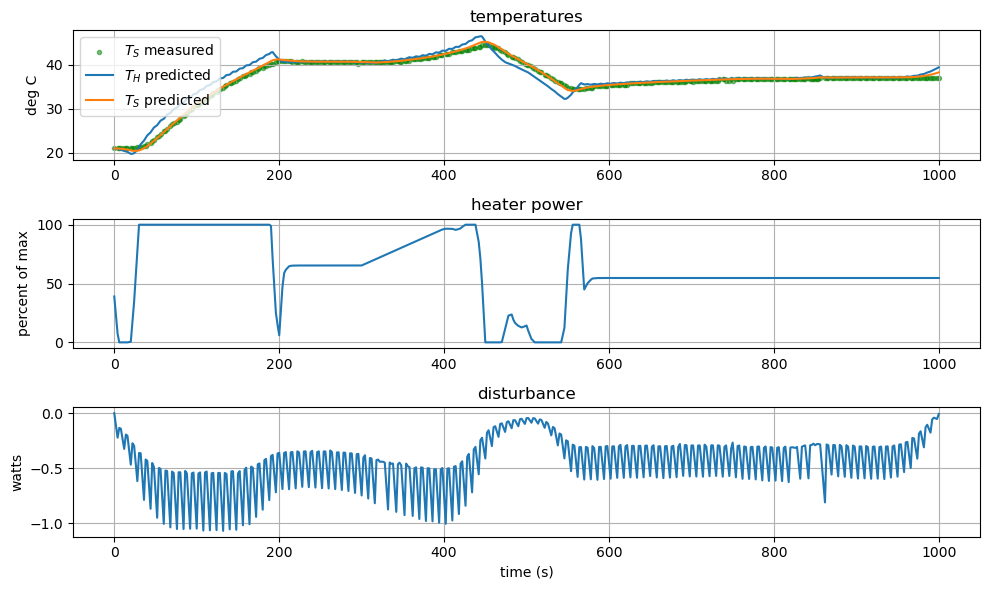

In [14]:
obs = TCLabPyomo('observe',
                 time_data,
                 u_data,
                 None,
                 None,
                 T1_data,
                obj_weight=10.0
)

obs.solve()
obs.plot()

## Parameter Estimation

It is also possible our model does not match the physics of the system (e.g., wrong assumptions) or our estimated parameters are no longer valid or both. To investigate the later, we can repeat the parameter estimation problem for earlier in the semester:


\begin{align*}
\min_{\hat{T}_H, \hat{T}_S, \hat{U_a}, \hat{U_b}, \hat{C_p^H}, \hat{C_p^S}} \int_{t - h}^t \|\hat{T}_S(t) - T_S(t)\|^2\,dt \\
\end{align*}

subject to

\begin{align*}
\hat{C_p^H} \frac{d\hat{T}_H}{dt} & = \hat{U_a} (T_{amb} - \hat{T}_H) + \hat{U_b} (\hat{T}_S - \hat{T}_H) + \alpha P u(t) + d(t)\\
\hat{C_p^S} \frac{d\hat{T}_S}{dt} & = - \hat{U_b} (\hat{T}_S - \hat{T}_H) 
\end{align*}

and initial conditions

\begin{align*}
T_H(t_0) & = T_{amb} \\
T_S(t_0) & = T_{amb}
\end{align*}

and (optionally) the assumption disturbance is zero

\begin{equation}
d(t) = 0
\end{equation}


Using data from your experiment, restimate the model parameters $U_a$, $U_b$, $C_p^H$, $C_p^S$.

NOTE: Depending on your computer's hardward and the version of Ipopt installed, the following code cell may take up to 2 minutes to solve.

### Assume no disturbance

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

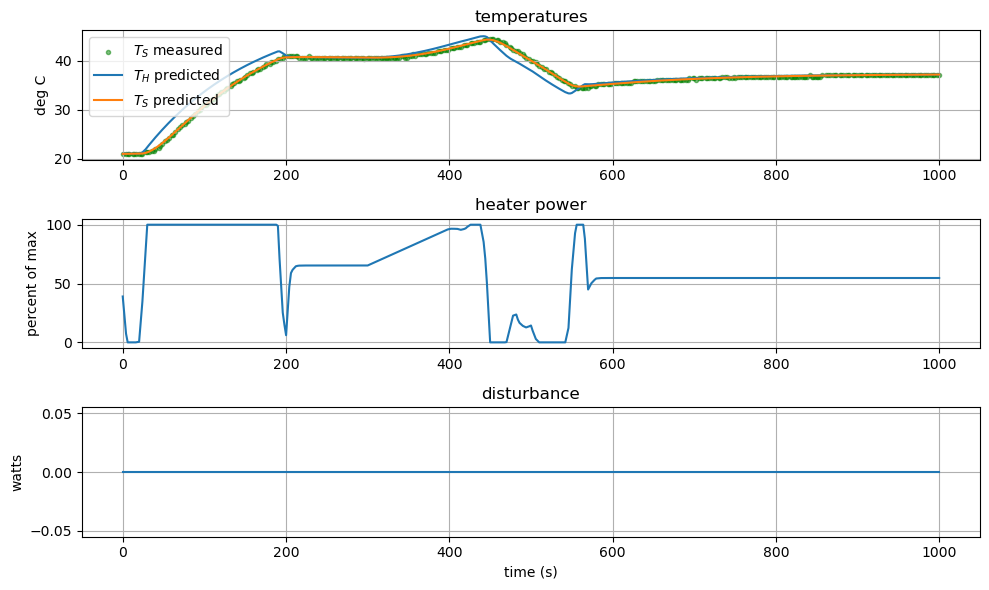

In [15]:
est = TCLabPyomo('estimate',
                 time_data,
                 u_data,
                 None, # assume d(t) = 0
                 None,
                 T1_data)

est.solve()
est.plot()

In [16]:
Ua, Ub, CpH, CpS = est.get_parameters()

est.print_parameters()

The value of Ua is 0.0538 Watts/degC.
The value of Ub is 0.0009 Watts/degC.
The value of CpH is 7.28 Joules/degC.
The value of CpS is 0.018 Joules/degC.


### With Perfect Knownledge of the Disturbance

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

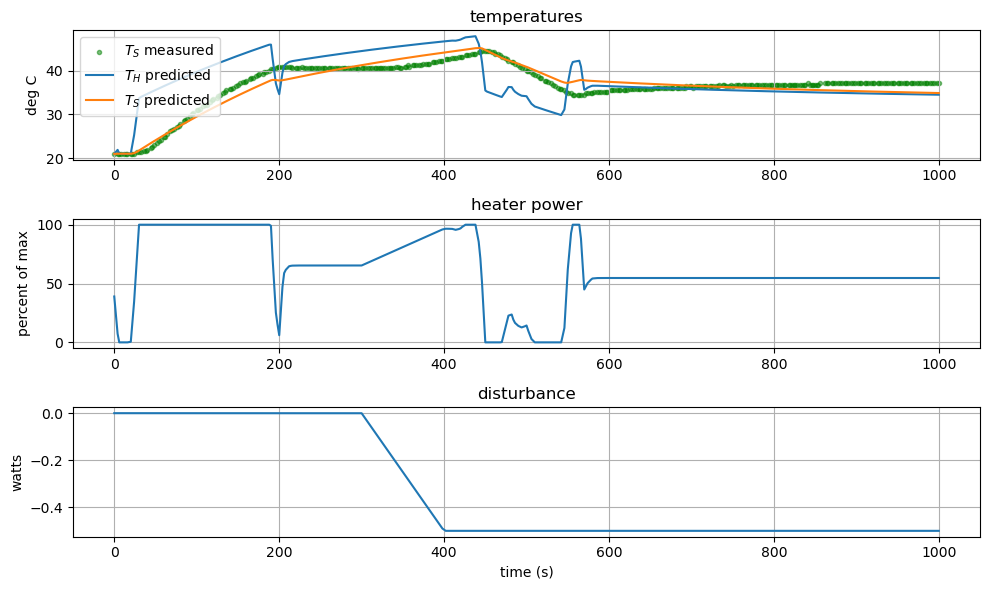

In [17]:
est = TCLabPyomo('estimate',
                 time_data,
                 u_data,
                 tclab_disturbance(time_data), # calculate disturbance at time points
                 None,
                 T1_data)

est.solve()
est.plot()

In [18]:
est.print_parameters()

The value of Ua is 0.0307 Watts/degC.
The value of Ub is 0.1002 Watts/degC.
The value of CpH is 0.01 Joules/degC.
The value of CpS is 10.0 Joules/degC.
